## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

raw_df_snf = d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]
surv = {'SNF':  raw_df_snf[raw_df_snf['salt2.Color'] < 0.3],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99)}
          #'HST': smap(300)} for viridis

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values
c_zcuts['SNF'] = surv['SNF']['salt2.Color'].values
c_err_zcuts['SNF'] = surv['SNF']['salt2.Color.err'].values

def set_cons(cons):
    global df
    
    names = []
    stretchs = []
    stretchs_err = []
    colors = []
    colors_err = []
    redshifts = []
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
            c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
            c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
            c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
            c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
    
    for survey in surveys:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        colors += list(c_zcuts[survey])
        colors_err += list(c_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        if survey != 'SNF':
            infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
            py += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])

    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'colors': colors,
                       'colors_err': colors_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    c_mean = np.mean(df.colors)
    c_std = np.std(df.colors)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(ipw.HBox([int_set_cons, btw, after]))

names = ['SNF' for i in range(len(z_zcuts['SNF']))]
stretchs = list(x1_zcuts['SNF'])
stretchs_err = list(x1_err_zcuts['SNF'])
colors = list(c_zcuts['SNF'])
colors_err = list(c_err_zcuts['SNF'])
redshifts = list(z_zcuts['SNF'])
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    colors += list(surv[survey].c.values)
    colors_err += list(surv[survey].cERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'colors': colors,
                        'colors_err': colors_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

df_nc = set_cons(False)
df_c = set_cons(True)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99)}
          #'HST': smap(300)} for viridis

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
        datax = np.sort(surv[su]['salt2.X1'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
        datax = np.sort(surv[su].x1.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

## Choix des bins pour les listes de redshifts et de stretch

In [4]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Définitions des dictionnaires

In [5]:
##############################################################################
############## $z[:z_max]$, $x_1[:z_max]$, data_all, mean et std #############
##############################################################################

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1])
    z_zcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zmax_cuts[survey]]
    x1_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zmax_cuts[survey]]
    c_zcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zmax_cuts[survey]]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])
    
##############################################################################
##################### $[:z_inf]$, $[z_sup:]$ et mean_inf #####################
##############################################################################

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys:
    zinf_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][0])
    z_zinfcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zinf_cuts[survey]]

z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys:
    zsup_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][1])
    z_zsupcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zsup_cuts[survey]]
   
##############################################################################
########################## $[z_max, inf:z_max, sup]$ #########################
##############################################################################

zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys:
    zbtw_cuts[survey] = np.where((df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][0])
                               & (df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1]))
    z_zbtwcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zbtw_cuts[survey]]

## Tracé des redshifts de l'échantillon choisi

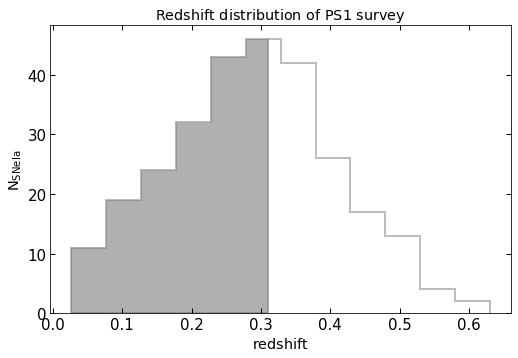

In [6]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

N, _, patches = ax.hist(dataz, bins = nb_z.value, color=colors[su.value],
                        alpha = .5, histtype='step', lw=2)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

if not btw.value and not cons.value and not after.value:
    ax.axvspan(np.min(surv[su.value].zCMB),
               z_max[su.value][1],
               color=colors[su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

if btw.value or (btw.value and cons.value):
    ax.axvspan(np.min(surv[su.value].zCMB),
               z_max[su.value][0],
               color=colors[su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])
    ax.axvspan(z_max[su.value][0],
               z_max[su.value][1],
               color=colors[su.value],
               alpha=.3, lw=2.0,
               clip_path=patches[0])

if cons.value and not btw.value:
    ax.axvspan(np.min(surv[su.value].zCMB),
           z_max[su.value][0],
           color=colors[su.value],
           alpha=.6, lw=2.0,
           clip_path=patches[0])

if after.value:
    ax.axvspan(np.min(surv[su.value].zCMB),
               np.max(surv[su.value].zCMB),
               color=colors[su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

ax.set_title(r'$\mathrm{Redshift\,\,distribution\,\,of\,\,}$' + str(su.value) +
             r'$\mathrm{\,\,survey}$', fontsize = 'x-large')

path = '../../../../Images/hist_' + su.value + '-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../../Images/png/hist_' + su.value + '-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé du stretch de l'échantillon choisi, coupé à zmax

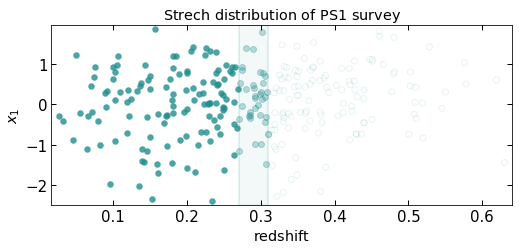

In [36]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.5])

prop = dict(marker="o")

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

if btw.value:
    ax.scatter(z_zinfcuts[su.value],
               x1_zinfcuts[su.value],
               edgecolor=alpha3colors[su.value],
               facecolor=alpha8colors[su.value],
               label=su.value, **prop)
    ax.scatter(z_zbtwcuts[su.value],
               x1_zbtwcuts[su.value],
               edgecolor=alpha3colors[su.value],
               facecolor=alpha3colors[su.value],
               **prop)

    ax.vline(z_max[su.value][0],
             color=colors[su.value],
             alpha=.1)
    ax.vline(z_max[su.value][1],
             color=colors[su.value],
             alpha=.1)
    ax.axvspan(z_max[su.value][0],
               z_max[su.value][1],
               color=colors[su.value],
               alpha=.05, lw=2.0)

else:
    ax.scatter(z_zcuts[su.value],
               x1_zcuts[su.value],
               edgecolor=alpha3colors[su.value],
               facecolor=alpha8colors[su.value],
               label=su.value, **prop)

if after.value:    
    ax.scatter(z_zsupcuts[su.value],
               x1_zsupcuts[su.value],
               edgecolor=alpha1colors[su.value],
               facecolor="None",
               **prop)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax.set_xlim(np.min(z_zinfcuts[su.value])-1e-2, np.max(z_zsupcuts[su.value])+1e-2)
ax.set_ylim(np.min(x1_zinfcuts[su.value])-1e-1, np.max(x1_zinfcuts[su.value])+1e-1)

plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,}$'
          + str(su.value)
          + r'$\mathrm{\,\,survey}$', fontsize = 'x-large')

path = '../../../Images/stretch_' + su.value + '-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.pdf'
fig.savefig(path, bbox_inches='tight')

## Tracé des stretchs cut à $z_{\text{max}}$

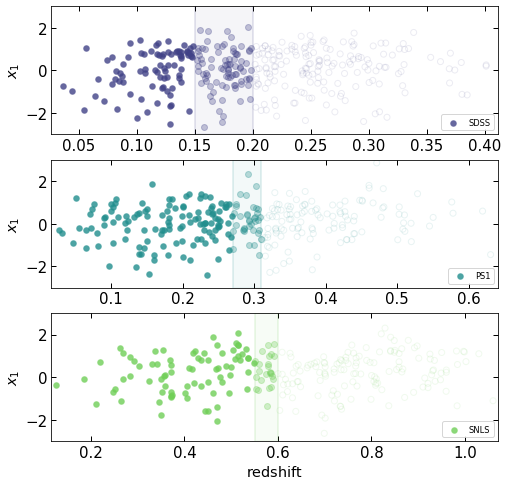

In [39]:
fig = plt.figure(figsize = [8, 8])

prop = dict(marker="o")

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

i = 1
for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha8colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha3colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)

    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha8colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   edgecolor=alpha1colors[survey],
                   facecolor="None",
                   **prop)

    ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

    ax.set_xlim(np.min(z_zinfcuts[survey])-1e-2, np.max(z_zsupcuts[survey])+1e-2)
    ax.set_ylim(-3, 3)
    
    ax.tick_params(direction = 'in',
                   length = 5, width = 1,
                   labelsize = 15,
                   top = True, right = True)
    
    ax.legend(ncol=1, loc='lower right', fontsize='small')
#              bbox_to_anchor=(0.82, 0.60))
    i += 1

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')

path = '../../../Images/stretchs-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.pdf'
fig.savefig(path, bbox_inches='tight')

## Modèle _base_ pour comparaison

In [75]:
gen = stretchevol.generic()
gen.set_model('Evol3G2M2S')
gen.set_data(df)
baseTOT = gen.fit()

## KS test

In [77]:
df_ncused = df_nc[df_nc['survey'] == 'PS1']
df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                  & (df_ncused['redshifts'] < 0.20)]
x1_ps = df_cmid.stretchs
c_ps = df_cmid.colors

df_ncused = df_nc[df_nc['survey'] == 'SDSS']
df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                  & (df_ncused['redshifts'] < 0.20)]
x1_sdss = df_cmid.stretchs
c_sdss = df_cmid.colors

x1_ks = scipy.stats.ks_2samp(x1_ps, x1_sdss)[1]
c_ks = scipy.stats.ks_2samp(c_ps, c_sdss)[1]

## Tracé des stretchs de surveys

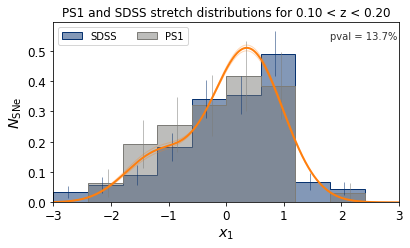

In [94]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

shift = [-0.05, 0.05]

for i, survey in enumerate(surveys[1:3]):
    #ax = fig.add_subplot(121)
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    df_clow = df_ncused[(df_ncused['redshifts'] > 0.10)
                      & (df_ncused['redshifts'] < 0.15)]
    df_cup = df_ncused[(df_ncused['redshifts'] > 0.15)
                     & (df_ncused['redshifts'] < 0.20)]
    df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                      & (df_ncused['redshifts'] < 0.20)]
    
    prop = {"range":[-3, 3], "bins":10}

    h, r = np.histogram(df_cmid.stretchs, density=False, **prop)
    
    xbin = np.mean([r[:-1], r[1:]], axis=0)
    xbin = xbin + shift[i]
    
    ybin, _ = np.histogram(df_cmid.stretchs, density=True, **prop)
    
    norm = h[1]/ybin[1]
    yerr = np.sqrt(h)/norm

    ax.hist(df_cmid.stretchs, density=True,
            histtype='step', fill=True, zorder=1,
            edgecolor=colors[survey],
            facecolor=alpha5colors[survey],
            label=survey, **prop)
    
    ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                marker="None", ls="None",
                lw=1, alpha=.5,
                ecolor=colors[survey])

x_lin = np.linspace(-3, 3, 1000)
pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.10),
                                      x_lin, 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                      x_lin, 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                      x_lin, 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
ax.plot(x_lin, pdfmodel_low, **baseprop)
ax.plot(x_lin, pdfmodel_mid, lw=2, color='C1')
ax.plot(x_lin, pdfmodel_upp, **baseprop)

ax.text(1.8, 0.54, 'pval = ' + '%.1f%%'%(x1_ks*100), alpha=.8)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$x_1$', fontsize = 'x-large')
ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

ax.set_xlim(-3, 3)

ax.legend(loc='upper left', fontsize='medium', ncol=2)
#plt.title('PS1 and SDSS stretch distributions for 0.10 < z < 0.15')
#plt.title('PS1 and SDSS stretch distributions for 0.15 < z < 0.20')
plt.title('PS1 and SDSS stretch distributions for 0.10 < z < 0.20')

path = '../../Images/pdf/stretchs-cut'
#path = path + '_SDSS_PS1-010-015.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
path = path + '_SDSS_PS1-010-020.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/stretchs-cut'
#path = path + '_SDSS_PS1-010-015.png'
#path = path + '_SDSS_PS1-015-020.png'
path = path + '_SDSS_PS1-010-020.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé des colors de surveys

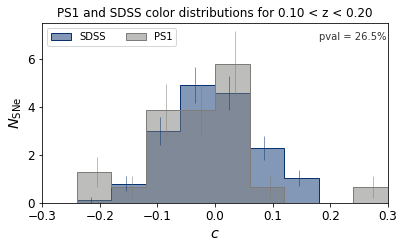

In [93]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

#shift = [-0.05, 0.05]
shift = [-0.005, 0.005]

for i, survey in enumerate(surveys[1:3]):
    #ax = fig.add_subplot(121)
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    df_clow = df_ncused[(df_ncused['redshifts'] > 0.10)
                      & (df_ncused['redshifts'] < 0.15)]
    df_cup = df_ncused[(df_ncused['redshifts'] > 0.15)
                     & (df_ncused['redshifts'] < 0.20)]
    df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                      & (df_ncused['redshifts'] < 0.20)]
    
    prop = {"range":[-0.3, 0.3], "bins":10}

    h, r = np.histogram(df_cmid.colors, density=False, **prop)
    
    xbin = np.mean([r[:-1], r[1:]], axis=0)
    xbin = xbin + shift[i]
    
    ybin, _ = np.histogram(df_cmid.colors, density=True, **prop)
    
    norm = h[1]/ybin[1]
    yerr = np.sqrt(h)/norm

    ax.hist(df_cmid.colors, density=True,
            histtype='step', fill=True, zorder=1,
            edgecolor=colors[survey],
            facecolor=alpha5colors[survey],
            label=survey, **prop)
    
    ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                marker="None", ls="None",
                lw=1, alpha=.5,
                ecolor=colors[survey])
    
ax.tick_params(labelsize=12)

ax.text(0.18, 6.8, 'pval = ' + '%.1f%%'%(c_ks*100), alpha=.8)

ax.set_xlabel(r'$c$', fontsize = 'x-large')
ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

ax.set_xlim(-0.3, 0.3)

ax.legend(loc='upper left', fontsize='medium', ncol=5)
#plt.title('PS1 and SDSS color distributions for 0.10 < z < 0.15')
#plt.title('PS1 and SDSS color distributions for 0.15 < z < 0.20')
plt.title('PS1 and SDSS color distributions for 0.10 < z < 0.20')

path = '../../Images/pdf/colors-cut'
#path = path + '_SDSS_PS1-010-015.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
path = path + '_SDSS_PS1-010-020.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/colors-cut'
#path = path + '_SDSS_PS1-010-015.png'
#path = path + '_SDSS_PS1-015-020.png'
path = path + '_SDSS_PS1-010-020.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé des stretchs et colors de survey 12x ou 21x

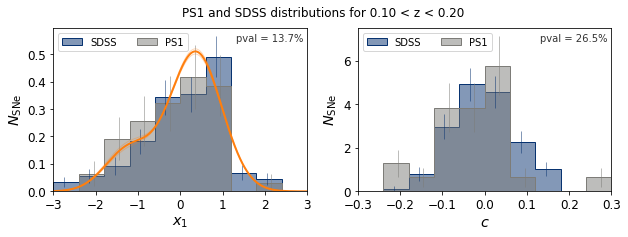

In [111]:
fig = plt.figure(figsize=[10, 3])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

for k in range(2):
    ax = fig.add_subplot(int('12' + str(k+1)))
    for i, survey in enumerate(surveys[1:3]):
        df_ncused = df_nc[df_nc['survey'] == survey]
        df_cused = df_c[df_c['survey'] == survey]
        df_clow = df_ncused[(df_ncused['redshifts'] > 0.10)
                          & (df_ncused['redshifts'] < 0.15)]
        df_cup = df_ncused[(df_ncused['redshifts'] > 0.15)
                         & (df_ncused['redshifts'] < 0.20)]
        df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                          & (df_ncused['redshifts'] < 0.20)]
        
        toplot = [df_cmid.stretchs, df_cmid.colors]
        torange = [[-3, 3], [-0.3, 0.3]]
        tolabel = [r'$x_1$', r'$c$']
        toname = ['stretch', 'color']
        shift = [[-0.05, 0.05], [-0.005, 0.005]]
        
        prop = {"range":torange[k], "bins":10}
    
        h, r = np.histogram(toplot[k], density=False, **prop)
        
        xbin = np.mean([r[:-1], r[1:]], axis=0)
        xbin = xbin + shift[k][i]
        
        ybin, _ = np.histogram(toplot[k], density=True, **prop)
        
        norm = h[1]/ybin[1]
        yerr = np.sqrt(h)/norm
    
        ax.hist(toplot[k], density=True,
                histtype='step', fill=True, zorder=1,
                edgecolor=colors[survey],
                facecolor=alpha5colors[survey],
                label=survey, **prop)
        
        ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                    marker="None", ls="None",
                    lw=1, alpha=.5,
                    ecolor=colors[survey])
        
    if k == 1:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                'pval = ' + '%.1f%%'%(c_ks*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
    else:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                'pval = ' + '%.1f%%'%(x1_ks*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
        x_lin = np.linspace(-3, 3, 1000)
        pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.10),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
        ax.plot(x_lin, pdfmodel_low, **baseprop)
        ax.plot(x_lin, pdfmodel_mid, lw=2, color='C1')
        ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
    ax.tick_params(labelsize=12)

    ax.set_xlabel(tolabel[k], fontsize = 'x-large')
    ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

    ax.set_xlim(torange[k][0], torange[k][-1])

    ax.legend(loc='upper left', fontsize='medium', ncol=5)
    plt.suptitle('PS1 and SDSS distributions for 0.10 < z < 0.20')

path = '../../Images/pdf/both-cut'
#path = path + '_SDSS_PS1-010-015.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
path = path + '_SDSS_PS1-010-020.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/both-cut'
#path = path + '_SDSS_PS1-010-015.png'
#path = path + '_SDSS_PS1-015-020.png'
path = path + '_SDSS_PS1-010-020.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Individual survey

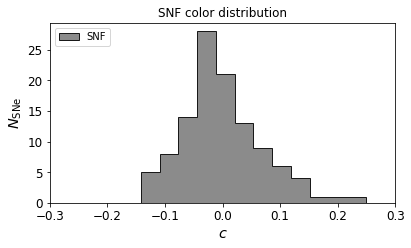

In [26]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

for survey in surveys[0:1]:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused.colors, bins='auto', density=False,
            histtype='step', fill=True, zorder=1,
            edgecolor=colors[survey],
            facecolor=alpha5colors[survey],
            label=survey)
    
ax.tick_params(labelsize=12)

#ax.set_xlabel(r'$x_1$', fontsize = 'x-large')
ax.set_xlabel(r'$c$', fontsize = 'x-large')
ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

#ax.set_xlim(-3, 3)
ax.set_xlim(-0.3, 0.3)
# for legend between
#ax.set_ylim(0, 1)

ax.legend(loc='upper left', fontsize='medium', ncol=5)
#plt.title('PS1 and SDSS stretch distributions for 0.10 < z < 0.15')
#plt.title('PS1 and SDSS stretch distributions for 0.15 < z < 0.20')
plt.title('SNF color distribution')
#plt.title('PS1 and SDSS color distributions for 0.15 < z < 0.20')

#path = '../../Images/pdf/stretchs-cut'
path = '../../Images/pdf/colors-cut'
path = path + '_SNF.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
fig.savefig(path, bbox_inches='tight')

#path = '../../Images/png/stretchs-cut'
path = '../../Images/png/colors-cut'
path = path + '_SNF.png'
#path = path + '_SDSS_PS1-015-020.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé total : histogrammes

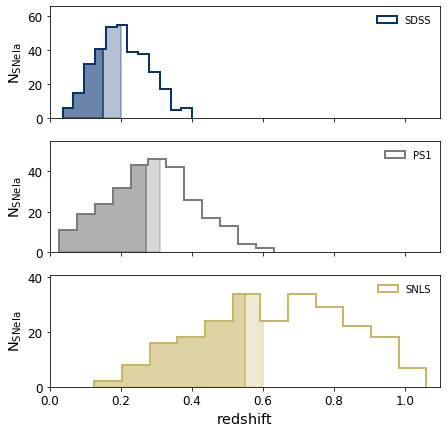

In [31]:
fig = plt.figure(figsize=[7, 7])
#fig = plt.figure(figsize=[15, 3])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

i = 1

for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    N, _, patches = ax.hist(surv[survey].zCMB, bins=nb_x.value,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    
    if not btw.value and not cons.value and not after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    if btw.value or (btw.value and cons.value):
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][0],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    if cons.value and not btw.value:
        ax.axvspan(np.min(surv[survey].zCMB),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

    if after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   np.max(surv[survey].zCMB),
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    
    if i == 3:
        ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    else:
        ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    #if i == 1:
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    ax.tick_params(labelsize = 12)
    #if i >= 2:
    #    ax.set_yticks([])
    
    ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)
    i += 1

#fig.savefig('../../Images/pdf/hist_surveys_cuts_75-'+smap.name+'.pdf', bbox_inches='tight')
#fig.savefig('../../Images/png/hist_surveys_cuts_75-'+smap.name+'.png', bbox_inches='tight', dpi=600)

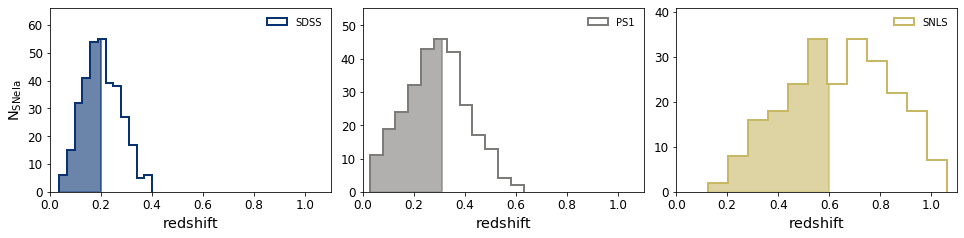

In [24]:
#fig = plt.figure(figsize=[5, 5])
fig = plt.figure(figsize=[15, 3])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

i = 1

# for vert
#left, width = 0.1, 0.85
#bottom, height = 0.11, 0.26
#yspan = 0.03

# for horiz
left, width = 0.1, 0.26
bottom, height = 0.11, 0.85
xspan = 0.03

for i, survey in enumerate(surveys[1:-1]):#[::-1]):
    # for vert
    #ax = fig.add_axes([left, bottom+i*(height+yspan), width, height])
    # for horiz
    ax = fig.add_axes([left+i*(width+xspan), bottom, width, height])
    N, _, patches = ax.hist(surv[survey].zCMB, bins=12,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    
    if not btw.value and not cons.value and not after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    if btw.value or (btw.value and cons.value):
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][0],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    if cons.value and not btw.value:
        ax.axvspan(np.min(surv[survey].zCMB),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

    if after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   np.max(surv[survey].zCMB),
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    
    #if i == 0:
    ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    #else:
    #    ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    if i == 0:
        ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    #if i >= 2:
    #    ax.set_yticks([])
    
    ax.tick_params(labelsize = 12)
    ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)

fig.savefig('../../Images/pdf/hist_surveys_horiz-'+smap.name+'.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/hist_surveys_horiz-'+smap.name+'.png', bbox_inches='tight', dpi=600)

### Définition des bins sur lesquels faire les violins

In [8]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

## Tracé total : $x_1$ at zmax_cons, btw, sup

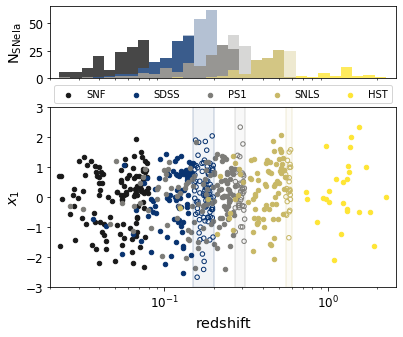

In [151]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
# for legend between
ax2 = fig.add_axes([0.1, 0.70, 0.6, 0.2])
# for legend down
#ax2 = fig.add_axes([0.1, 0.65, 0.6, 0.2])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

#_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in surveys:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **prop, alpha=.2)

test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]] for survey in surveys])

it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
stacked = np.array([test[i][k] for i,k in it])
hstclrs = [[list(alpha8colors.values())[i],
            list(alpha3colors.values())[i]] for i in range(5)]
hstclrs = [item for sublist in hstclrs for item in sublist]

order = [3, 2, 1, 0, 4]
stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
hstclrs_bt = [list(alpha8colors.values())[i] for i in order]\
           + [list(alpha3colors.values())[i] for i in order]

ax2.hist(stacked_bt,
         stacked=True,
         bins=10**np.linspace(np.log10(np.min(df_nc.redshifts)),
                              np.log10(np.max(df_nc.redshifts)), 30),
         histtype='stepfilled',
         color=hstclrs_bt)

ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')
ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.set_xlim(0.02, 2.6)
# for legend between
ax.set_ylim(-3, 3)
# for legend down
#ax.set_ylim(-3.6, 3)
ax.set_xscale('log')

ax2.set_xlim(0.02, 2.6)
ax2.set_xscale('log')
ax2.get_xaxis().set_ticks([])

from matplotlib.lines import Line2D

SNfleg = Line2D([0], [0], color=colors['SNF'],linewidth=0, marker='o')
SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='o')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='o')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='o')
HSTleg = Line2D([0], [0], color=colors['HST'],linewidth=0, marker='o')
labels = ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST']

# for figsize(7,5), legend between
ax.legend(loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))
# for figsize(7,5), legend down
#ax.legend(loc='lower center', fontsize='medium', ncol=5)

path = '../../Images/pdf/stretchs-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/stretchs-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé total : $c$ at zmax_cons, btw, sup

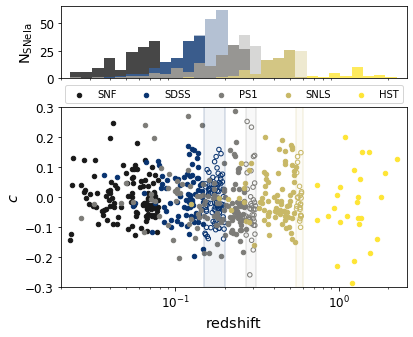

In [25]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
# for legend between
ax2 = fig.add_axes([0.1, 0.70, 0.6, 0.2])
# for legend down
#ax2 = fig.add_axes([0.1, 0.65, 0.6, 0.2])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

#_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in surveys:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   c_zinfcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   c_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   c_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   c_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **prop, alpha=.2)

test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]] for survey in surveys])

it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
stacked = np.array([test[i][k] for i,k in it])
hstclrs = [[list(alpha8colors.values())[i],
            list(alpha3colors.values())[i]] for i in range(5)]
hstclrs = [item for sublist in hstclrs for item in sublist]

order = [3, 2, 1, 0, 4]
stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
hstclrs_bt = [list(alpha8colors.values())[i] for i in order]\
           + [list(alpha3colors.values())[i] for i in order]

ax2.hist(stacked_bt,
         stacked=True,
         bins=10**np.linspace(np.log10(np.min(df_nc.redshifts)),
                              np.log10(np.max(df_nc.redshifts)), 30),
         histtype='stepfilled',
         color=hstclrs_bt)

ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$c$', fontsize = 'x-large')
ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.set_xlim(0.02, 2.6)
# for legend between
ax.set_ylim(-0.3, 0.3)
# for legend down
#ax.set_ylim(-3.6, 3)
ax.set_xscale('log')

ax2.set_xlim(0.02, 2.6)
ax2.set_xscale('log')
ax2.get_xaxis().set_ticks([])

# for figsize(7,5), legend between
ax.legend(loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))
# for figsize(7,5), legend down
#ax.legend(loc='lower center', fontsize='medium', ncol=5)

path = '../../Images/pdf/colors-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/colors-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$

### Définition des bins sur lesquels faire les moyennes

In [35]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(df_nc.redshifts, histedges_equalN(df_nc.redshifts, 6))
_, bins_cons = np.histogram(df_c.redshifts, histedges_equalN(df_c.redshifts, 6))

### Means for combined sample

In [79]:
slices = []
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
c_comp_mean = np.zeros(6)
c_comp_std = np.zeros(6)

slices_nhst = []
z_comp_mean_nhst = np.zeros(6)
z_comp_std_nhst = np.zeros(6)
x1_comp_mean_nhst = np.zeros(6)
x1_comp_std_nhst = np.zeros(6)
c_comp_mean_nhst = np.zeros(6)
c_comp_std_nhst = np.zeros(6)

slices_full = []
z_comp_mean_full = np.zeros(6)
z_comp_std_full = np.zeros(6)
x1_comp_mean_full = np.zeros(6)
x1_comp_std_full = np.zeros(6)
c_comp_mean_full = np.zeros(6)
c_comp_std_full = np.zeros(6)

df_nhst = df_nc[df_nc['survey'] != 'HST']

for i in range(6):
    slices.append(np.where((df_nc.redshifts > bins[i])
                         & (df_nc.redshifts <= bins[i+1])))
    z_comp_mean[i] = np.mean(df_nc.redshifts.values[slices[i]])
    z_comp_std[i] = np.std(df_nc.redshifts.values[slices[i]])
    x1_comp_mean[i] = np.mean(df_nc.stretchs.values[slices[i]])
    x1_comp_std[i] = np.std(df_nc.stretchs.values[slices[i]])
    c_comp_mean[i] = np.mean(df_nc.colors.values[slices[i]])
    c_comp_std[i] = np.std(df_nc.colors.values[slices[i]])
    
    slices_nhst.append(np.where((df_nhst.redshifts > bins[i])
                              & (df_nhst.redshifts <= bins[i+1])))
    z_comp_mean_nhst[i] = np.mean(df_nhst.redshifts.values[slices_nhst[i]])
    z_comp_std_nhst[i] = np.std(df_nhst.redshifts.values[slices_nhst[i]])
    x1_comp_mean_nhst[i] = np.mean(df_nhst.stretchs.values[slices_nhst[i]])
    x1_comp_std_nhst[i] = np.std(df_nhst.stretchs.values[slices_nhst[i]])
    c_comp_mean_nhst[i] = np.mean(df_nhst.colors.values[slices_nhst[i]])
    c_comp_std_nhst[i] = np.std(df_nhst.colors.values[slices_nhst[i]]) 

    slices_full.append(np.where((df_full.redshifts > bins[i])
                              & (df_full.redshifts <= bins[i+1])))
    z_comp_mean_full[i] = np.mean(df_full.redshifts.values[slices_full[i]])
    z_comp_std_full[i] = np.std(df_full.redshifts.values[slices_full[i]])
    x1_comp_mean_full[i] = np.mean(df_full.stretchs.values[slices_full[i]])
    x1_comp_std_full[i] = np.std(df_full.stretchs.values[slices_full[i]])
    c_comp_mean_full[i] = np.mean(df_full.colors.values[slices_full[i]])
    c_comp_std_full[i] = np.std(df_full.colors.values[slices_full[i]]) 
    
slices_cons = []
z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)
x1_comp_mean_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
c_comp_mean_cons = np.zeros(6)
c_comp_std_cons = np.zeros(6)

for i in range(6):
    slices_cons.append(np.where((df_c.redshifts > bins[i]) & (df_c.redshifts <= bins[i+1])))
    z_comp_mean_cons[i] = np.mean(df_c.redshifts.values[slices_cons[i]])
    z_comp_std_cons[i] = np.std(df_c.redshifts.values[slices_cons[i]])
    x1_comp_mean_cons[i] = np.mean(df_c.stretchs.values[slices_cons[i]])
    x1_comp_std_cons[i] = np.std(df_c.stretchs.values[slices_cons[i]])
    c_comp_mean_cons[i] = np.mean(df_c.colors.values[slices_cons[i]])
    c_comp_std_cons[i] = np.std(df_c.colors.values[slices_cons[i]])

bins_text = bins
bins_text[-1] = 1.4
shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.012, 0.017],
                [0.015, 0.023],
                [0.029, 0.040],
                [0.180, 0.210]]

### Means for samples binned

In [66]:
z_means = dict()
z_stds = dict()
x1_means = dict()
x1_stds = dict()
c_means = dict()
c_stds = dict()
xerrs = dict()
yerrs_c = dict()
yerrs_x = dict()

for survey in surveys:
    df_ncused = df_nc[df_nc['survey'] == survey]
    slicess = [np.where((df_ncused.redshifts > bins[i])
                      & (df_ncused.redshifts <= bins[i+1]))
               for i in range(6)]
    z_means[survey] = [np.mean(df_ncused.redshifts.values[slicess[i]]) for i in range(6)]
    z_stds[survey] = [np.std(df_ncused.redshifts.values[slicess[i]]) for i in range(6)]
    x1_means[survey] = [np.mean(df_ncused.stretchs.values[slicess[i]]) for i in range(6)]
    x1_stds[survey] = [np.std(df_ncused.stretchs.values[slicess[i]]) for i in range(6)]
    c_means[survey] = [np.mean(df_ncused.colors.values[slicess[i]]) for i in range(6)]
    c_stds[survey] = [np.std(df_ncused.colors.values[slicess[i]]) for i in range(6)]
    
    xerrs[survey] = np.asarray(z_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.redshifts.values[slicess[i]])) for i in range(6)])
    
    yerrs_c[survey] = np.asarray(c_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.colors.values[slicess[i]])) for i in range(6)])
    
    yerrs_x[survey] = np.asarray(x1_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.stretchs.values[slicess[i]])) for i in range(6)])

## Tracé pour stretch

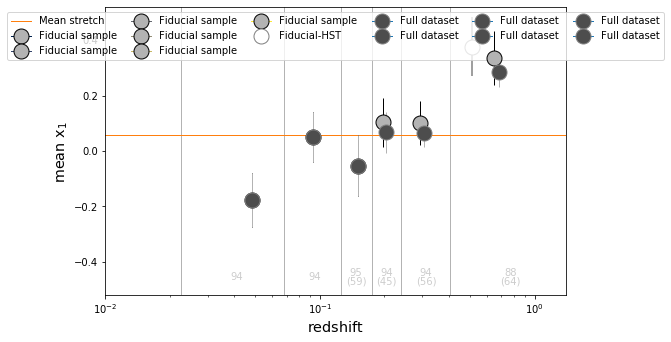

In [83]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5", mfc='.3')
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)
  
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], x1_means[survey],
#                xerr=xerrs[survey], yerr=yerrs_x[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                color=vmap_s[i], **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax.errorbar(z_comp_mean_nhst[-1], x1_comp_mean_nhst[-1],
            xerr=z_comp_std_nhst[-1]/np.sqrt(len(df_nhst.redshifts.values[slices_nhst[-1]])),
            yerr=x1_comp_std_nhst[-1]/np.sqrt(len(df_nhst.stretchs.values[slices_nhst[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')
            #marker='o', ms=15, ecolor='k', mfc=None)
    
for i in range(6):
    ax.errorbar(z_comp_mean_full[i], x1_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=x1_comp_std_full[i]/np.sqrt(len(df_full.stretchs.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
    
#############################################################################################

#for i, c in zip(range(6), vmap_s):
#    ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
#                 xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                 yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
#                 color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
#ax.set_ylim(-0.80, 0.60)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.legend(ncol=6, loc='upper center', columnspacing=1.4)

fig.savefig('../../Images/pdf/mean_stretchs-nHST_full.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mean_stretchs-nHST_full.png', bbox_inches='tight', dpi=600)

## Stretch means

In [82]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)
    
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], c_means[survey],
#                xerr = xerrs[survey], yerr = yerrs_c[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean[i], c_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=c_comp_std[i]/np.sqrt(len(df_nc.colors.values[slices[i]])),
                **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax.errorbar(z_comp_mean_nhst[-1], c_comp_mean_nhst[-1],
            xerr=z_comp_std_nhst[-1]/np.sqrt(len(df_nhst.redshifts.values[slices_nhst[-1]])),
            yerr=c_comp_std_nhst[-1]/np.sqrt(len(df_nhst.colors.values[slices_nhst[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')

for i in range(6):
    ax.errorbar(z_comp_mean_full[i], c_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=c_comp_std_full[i]/np.sqrt(len(df_full.colors.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
#############################################################################################

#for i in range(6):
#    ax.errorbar(z_comp_mean_cons[i], c_comp_mean_cons[i],
#                 xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                 yerr = c_comp_std_cons[i]/np.sqrt(len(df_c.colors.values[slices_cons[i]])),
#                 **prop, alpha=.3, zorder=9, lw=1)

ax.hline(np.mean(df_nc.colors), color='C1', lw=1, ls='-', label='Mean color')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465/13,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45/13,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48/13,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,c}$ ", fontsize="x-large")

ax.set_ylim(-0.04, 0.04)
#ax.set_ylim(-0.1, 0.1)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=6, loc='upper center', columnspacing=1.4)

fig.savefig('../../Images/pdf/mean_colors-nHST_full.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mean_colors-nHST_full.png', bbox_inches='tight', dpi=600)

SyntaxError: positional argument follows keyword argument unpacking (<ipython-input-82-3836b517a355>, line 42)

### Définitions pour loi

In [7]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

def delta(z):
    return stretchevol.MockEvol().delta(z)

def age_law_snf(z):
    """Analytical law with snf results"""
    return delta(z)*snf_mu_1 + (1-delta(z))*(snf_a*snf_mu_1 + (1-snf_a)*snf_mu_2)

### Tracé

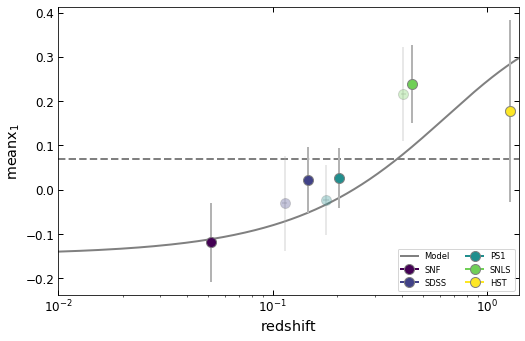

In [22]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys:
    ax.errorbar(z_mean[survey], x1_mean[survey],
                xerr = z_std[survey]/np.sqrt(len(z_zcuts[survey])),
                yerr = x1_std[survey]/np.sqrt(len(x1_zcuts[survey])),
                color = colors[survey], label = survey, **prop)
    ax.errorbar(z_inf_mean[survey], x1_inf_mean[survey], 
                xerr = z_inf_std[survey]/np.sqrt(len(z_zinfcuts[survey])),
                yerr = x1_inf_std[survey]/np.sqrt(len(x1_zinfcuts[survey])),
                color = colors[survey], **prop,
                alpha=.3)
    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(x1_mean.values())), lw=2, ls="--", color="0.5")

zz = np.linspace(0,1.4,1000)

ax.plot(zz, age_law_snf(zz),
        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean x}_1$ ", fontsize="x-large")

ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')
#ax.set_ylim(-0.3, 0.4)

ax.legend(loc='lower right',ncol=2, fontsize="small")

fig=plt.gcf()
fig.savefig('../../../Images/stretchevol_model_maglim-cuts.pdf', bbox_inches='tight')

## Tracé des $c_{\text{mean}}$ en fonction des $z_{\text{mean}}$

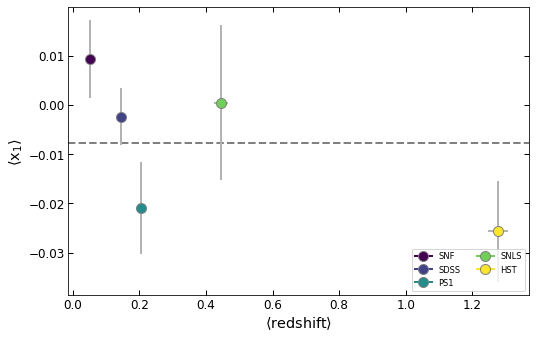

In [63]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
#    if i != 4:
#        continue
    ax.errorbar(list(z_mean.values())[i], list(c_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(c_std.values())[i]/np.sqrt(len(list(c_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(c_mean.values())), lw=2, ls="--", color="0.5")

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')

## $\delta(z)$ evolution

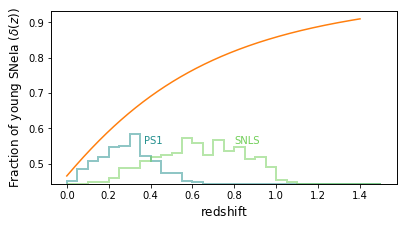

In [35]:
fig = plt.figure(figsize=[6, 3])
ax = fig.add_axes([0.1, 0.15, 0.8, 0.8])
axt = ax.twinx()

z_lin = np.linspace(0., 1.4, 1000)

ax.plot(z_lin, stretchevol.MockEvol().delta(z_lin), color="C1")

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize='large')
ax.set_ylabel(r'Fraction of young SNeIa $(\delta(z))$', fontsize='large')

prop = dict(histtype='step', density=False, lw=2, alpha=.5, range=(0, 1.5), bins=30)

axt.hist(df_full[df_full['survey'] == 'PS1'].redshifts, color=colors['PS1'], weights=[0.5]*len(df_full[df_full['survey'] == 'PS1'].redshifts), **prop)
#axt.hist(df_full[df_full['survey'] == 'SDSS'].redshifts, color=colors['SDSS'], weights=[0.3]*len(df_full[df_full['survey'] == 'SDSS'].redshifts), **prop)
axt.hist(df_full[df_full['survey'] == 'SNLS'].redshifts, color=colors['SNLS'], **prop)
axt.set_ylim(0, 90)

axt.text(0.37, 20, 'PS1', va='bottom', ha='left', color=colors['PS1'])
axt.text(0.80, 20, 'SNLS', va='bottom', ha='left', color=colors['SNLS'])

axt.set_yticks([])

fig.savefig('../../../../Images/deltaz_hist.pdf', bbox_inches='tight')
fig.savefig('../../../../Images/png/deltaz_hist.png', bbox_inches='tight', dpi=600)